## **Hugging Face Model Cards: Collection, Preprocessing and Analysis**

In [3]:
from huggingface_hub import ModelCard
from huggingface_hub import list_models
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import json
import csv
import re
from collections import Counter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import emoji
import spacy


### **Model Cards Collection:**

In [ ]:
models = list(list_models(sort="downloads", direction=-1, limit=100000, full=True))

In [ ]:
data = []
model_cards = {}

lock = threading.Lock()

def process_model(model):
    try:
        card = ModelCard.load(model.id)
        content = card.content.strip()
        if content:
            has_card = True
            card_length = len(content)
            with lock:
                model_cards[model.id] = content
        else:
            has_card = False
            card_length = 0

        with lock:
            data.append({
                "model_id": model.id,
                "author": getattr(model, "author", None),
                "created_at": getattr(model, "created_at", None).isoformat() if getattr(model, "created_at", None) else None,
                "last_modified": getattr(model, "last_modified", None).isoformat() if getattr(model, "last_modified", None) else None,
                "downloads": getattr(model, "downloads", None),
                "likes": getattr(model, "likes", None),
                "has_card": has_card,
                "card_length": card_length,
                "library_name": getattr(model, "library_name", None),
                "tags": ", ".join(getattr(model, "tags", [])) if getattr(model, "tags", None) else None,
                "pipeline_tag": getattr(model, "pipeline_tag", None),
            })

    except Exception:
        with lock:
            data.append({
            "model_id": model.id,
            "author": getattr(model, "author", None),
            "created_at": getattr(model, "created_at", None).isoformat() if getattr(model, "created_at", None) else None,
            "last_modified": getattr(model, "last_modified", None).isoformat() if getattr(model, "last_modified", None) else None,
            "downloads": getattr(model, "downloads", None),
            "likes": getattr(model, "likes", None),
            "has_card": False,
            "card_length": 0,
            "library_name": getattr(model, "library_name", None),
            "tags": ", ".join(getattr(model, "tags", [])) if getattr(model, "tags", None) else None,
            "pipeline_tag": getattr(model, "pipeline_tag", None),
            })


CHECKPOINT_EVERY = 1000

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(process_model, model): model for model in models}

    for i, future in enumerate(as_completed(futures), 1):
        model = futures[future]
        try:
            future.result()
        except Exception as e:
            print(f"Error procesando {model.id}: {e}")



# Periodic saving
        if i % CHECKPOINT_EVERY == 0:
            with lock:
                if data:
                    # Save tabular summary to CSV
                    with open("metadata_checkpoint.csv", "w", newline="", encoding="utf-8") as f:
                        writer = csv.DictWriter(f, fieldnames=data[0].keys())
                        writer.writeheader()
                        writer.writerows(data)

                # Save model cards in a JSON file
                with open("model_cards_checkpoint.json", "w", encoding="utf-8") as f:
                    json.dump(model_cards, f, ensure_ascii=False, indent=2)

            print(f"Checkpoint saved after processing {i} models")

In [ ]:
data = pd.read_csv("metadata_checkpoint.csv")
data.head()

,model_id,author,created_at,last_modified,downloads,likes,has_card,card_length,library_name,tags,pipeline_tag
0,pyannote/speaker-diarization-3.1,pyannote,2023-11-16T08:19:01+00:00,2024-05-10T19:43:23+00:00,16721804,1165,True,10959,pyannote-audio,"pyannote-audio, pyannote, pyannote-audio-pipel...",automatic-speech-recognition
1,pyannote/segmentation-3.0,pyannote,2023-09-22T12:03:10+00:00,2024-05-10T19:35:46+00:00,18518237,604,True,4645,pyannote-audio,"pyannote-audio, pytorch, pyannote, pyannote-au...",voice-activity-detection
2,tech4humans/yolov8s-signature-detector,tech4humans,2025-01-03T17:32:18+00:00,2025-04-05T00:37:03+00:00,41151738,42,True,19059,ultralytics,"ultralytics, tensorboard, onnx, object-detecti...",object-detection
3,timm/mobilenetv3_small_100.lamb_in1k,timm,2022-12-16T05:38:36+00:00,2025-01-21T18:21:16+00:00,126091014,38,True,4441,timm,"timm, pytorch, safetensors, image-classificati...",image-classification
4,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers,2022-03-02T23:29:05+00:00,2025-03-06T13:37:44+00:00,90137861,3929,True,10454,sentence-transformers,"sentence-transformers, pytorch, tf, rust, onnx...",sentence-similarity


In [19]:
data.shape

(100000, 11)

In [20]:
data = data.sort_values(by="downloads", ascending=False)
data.head(10)

,model_id,author,created_at,last_modified,downloads,likes,has_card,card_length,library_name,tags,pipeline_tag
3,timm/mobilenetv3_small_100.lamb_in1k,timm,2022-12-16T05:38:36+00:00,2025-01-21T18:21:16+00:00,126091014,38,True,4441,timm,"timm, pytorch, safetensors, image-classificati...",image-classification
6,Falconsai/nsfw_image_detection,Falconsai,2023-10-13T23:50:01+00:00,2025-04-06T13:42:07+00:00,98988953,824,True,9142,transformers,"transformers, pytorch, safetensors, vit, image...",image-classification
4,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers,2022-03-02T23:29:05+00:00,2025-03-06T13:37:44+00:00,90137861,3929,True,10454,sentence-transformers,"sentence-transformers, pytorch, tf, rust, onnx...",sentence-similarity
7,dima806/fairface_age_image_detection,dima806,2024-12-06T14:59:20+00:00,2024-12-15T19:54:53+00:00,60653441,41,True,1198,transformers,"transformers, safetensors, vit, image-classifi...",image-classification
8,google-bert/bert-base-uncased,google-bert,2022-03-02T23:29:04+00:00,2024-02-19T11:06:12+00:00,55171860,2417,True,10516,transformers,"transformers, pytorch, tf, jax, rust, coreml, ...",fill-mask
2,tech4humans/yolov8s-signature-detector,tech4humans,2025-01-03T17:32:18+00:00,2025-04-05T00:37:03+00:00,41151738,42,True,19059,ultralytics,"ultralytics, tensorboard, onnx, object-detecti...",object-detection
1,pyannote/segmentation-3.0,pyannote,2023-09-22T12:03:10+00:00,2024-05-10T19:35:46+00:00,18518237,604,True,4645,pyannote-audio,"pyannote-audio, pytorch, pyannote, pyannote-au...",voice-activity-detection
9,pyannote/wespeaker-voxceleb-resnet34-LM,pyannote,2023-11-13T15:32:31+00:00,2024-05-10T19:36:24+00:00,17865623,75,True,3288,pyannote-audio,"pyannote-audio, pytorch, pyannote, pyannote-au...",NaN
5,sentence-transformers/all-mpnet-base-v2,sentence-transformers,2022-03-02T23:29:05+00:00,2025-08-19T10:14:25+00:00,16922032,1161,True,11612,sentence-transformers,"sentence-transformers, pytorch, onnx, safetens...",sentence-similarity
0,pyannote/speaker-diarization-3.1,pyannote,2023-11-16T08:19:01+00:00,2024-05-10T19:43:23+00:00,16721804,1165,True,10959,pyannote-audio,"pyannote-audio, pyannote, pyannote-audio-pipel...",automatic-speech-recognition


In [23]:
data.isnull().sum()

model_id             0
author               0
created_at           0
last_modified        0
downloads            0
likes                0
has_card             0
card_length          0
library_name     22544
tags                 0
pipeline_tag     52494
dtype: int64

In [24]:
data["has_card"].value_counts()

has_card
True     63065
False    36935
Name: count, dtype: int64

In [ ]:
PLACEHOLDER_PATTERNS = [
    r"more information needed",
    r"this model card has been automatically generated",
    r"provide a quick summary of what the model is/does",
    r"<!--.*?-->",  # HTML comments
]


# Compute meaningful content length
def meaningful_content_length(content: str) -> tuple[int, int]:
    lines = content.splitlines()
    useful_lines = []
    for line in lines:
        stripped = line.strip()
        if not stripped:
            continue
        # skip the line only when it contains a placeholder and nothing else
        if any(re.fullmatch(pat, stripped, flags=re.IGNORECASE | re.DOTALL) for pat in PLACEHOLDER_PATTERNS):
            continue
        useful_lines.append(stripped)
    return len(" ".join(useful_lines)), len(useful_lines)


# Check if a Model Card is valid
def has_valid_card(content: str, min_length: int = 100, min_lines: int = 2) -> bool:
    total_length, num_lines = meaningful_content_length(content)
    return total_length >= min_length and num_lines >= min_lines


In [27]:
with open("model_cards_checkpoint.json", "r", encoding="utf-8") as f:
    model_cards = json.load(f)

In [ ]:
# Save all Model Cards to a single .txt file
with open("all_model_cards.txt", "w", encoding="utf-8") as f:
    for model_id, content in model_cards.items():
        f.write(f"@@@MODEL_CARD_START@@@ {model_id}\n")
        f.write(content)
        f.write("\n\n")  # separate each Model Card with a blank line

### **Steps followed in the preprocessing of Model Cards:**

1. Extract headers from all Model Cards (lines with Markdown heading symbols: #, ##, ### o ####).
2. Normalize headers.
3. Remove placeholder or non-informative headers.
4. Select most common headers.
5. Identify sections of interest using a keyword-based aproach to detect headers related to bias, fairness, and responsible AI.
6. Manual review of candidate sections.



In [ ]:
with open("all_model_cards.txt", "r", encoding="utf-8") as f:
    content = f.read()

# Split the content by individual models
model_cards_list = content.split("@@@MODEL_CARD_START@@@ ")

# Remove empty entries and whitespace
model_cards_list = [c.strip() for c in model_cards_list if c.strip()]

In [30]:
len(model_cards_list)

63065

In [ ]:
# Extract model_id and content
cards = []
no_card_ids = []  # to store models without a valid card

for model in model_cards_list:
    lines = model.splitlines()
    if not lines:
        continue
    model_id = lines[0].strip()
    card_content = "\n".join(lines[1:])


    if not has_valid_card(card_content):
        no_card_ids.append(model_id)  # store ids of invalid cards
        continue  # skip these cards
    
    cards.append((model_id, card_content))

In [32]:
len(no_card_ids)

1400

In [33]:
len(cards)

61665

In [ ]:
cards[2] # Each entry in cards is a tuple: (model_id, card_content)

('tech4humans/yolov8s-signature-detector',
 '---\nlicense: agpl-3.0\nbase_model:\n- Ultralytics/YOLOv8\npipeline_tag: object-detection\ndatasets:\n- tech4humans/signature-detection\nmetrics:\n- f1\n- precision\n- recall\nlibrary_name: ultralytics\nlibrary_version: 8.0.239\ninference: false\ntags:\n- object-detection\n- signature-detection\n- yolo\n- yolov8\n- pytorch\nmodel-index:\n- name: tech4humans/yolov8s-signature-detector\n  results:\n  - task:\n      type: object-detection\n    dataset:\n      name: tech4humans/signature-detection\n      type: tech4humans/signature-detection\n      split: test\n    metrics:\n    - type: precision\n      value: 0.94499\n      name: mAP@0.5\n    - type: precision\n      value: 0.6735\n      name: mAP@0.5:0.95\n    - type: precision\n      value: 0.947396\n      name: precision\n    - type: recall\n      value: 0.897216\n      name: recall\n    - type: f1\n      value: 0.921623\n---\n\n# **YOLOv8s - Handwritten Signature Detection**\n\nThis reposit

In [35]:
data.loc[data["model_id"].isin(no_card_ids), "has_card"] = False

data[data["has_card"] == False].head()

,model_id,author,created_at,last_modified,downloads,likes,has_card,card_length,library_name,tags,pipeline_tag
71,unslothai/1,unslothai,2024-07-14T03:05:31+00:00,2024-07-14T03:07:01+00:00,3673072,1,False,43,transformers,"transformers, safetensors, llama, feature-extr...",feature-extraction
81,ggml-org/models-moved,ggml-org,2023-12-18T17:40:16+00:00,2025-04-03T13:38:51+00:00,3443917,11,False,92,NaN,"gguf, endpoints_compatible, region:us",NaN
140,unslothai/aws,unslothai,2024-03-31T16:44:21+00:00,2024-07-06T22:41:24+00:00,1977175,1,False,60,transformers,"transformers, safetensors, llama, feature-extr...",feature-extraction
141,unslothai/repeat,unslothai,2024-07-07T16:55:01+00:00,2024-07-07T16:55:04+00:00,1939325,0,False,43,transformers,"transformers, safetensors, llama, feature-extr...",feature-extraction
163,unslothai/vram-24,unslothai,2024-07-07T17:02:11+00:00,2024-07-07T17:02:52+00:00,1539044,0,False,43,transformers,"transformers, safetensors, llama, feature-extr...",feature-extraction


In [ ]:
# Extract headers from Model Cards
headers_list = []

for model_id, card_content in cards:
    header = re.findall(r'^\s*#+\s+(.*)', card_content, flags=re.MULTILINE)
    headers_list.extend(header)


# Normalize headers (remove emojis, punctuation, etc.)
def normalize_header(header):
    # remove '#' and leading spaces
    header_clean = re.sub(r'^#+\s*', '', header)
    # remove leading numbers
    header_clean = re.sub(r'^\d+\s*', '', header_clean)
    # remove parentheses and brackets
    header_clean = re.sub(r'[\(\)\[\]]', '', header_clean)
    # remove punctuation and emojis
    header_clean = re.sub(r'[^\w\s&]', '', header_clean)
    # replace '&' with 'and'
    header_clean = re.sub(r'&', 'and', header_clean)
    # replace multiple spaces with a single space
    header_clean = re.sub(r'\s+', ' ', header_clean)
    # remove line breaks
    header_clean = re.sub(r'\n', ' ', header_clean)

    header_clean = header_clean.lower().strip()
    
    # ignore headers that are placeholders
    if header_clean.endswith('optional') or header_clean == 'more information needed' or header_clean == 'model card for model id':
        return None
    
    return header_clean


# normalized_h = []
# for header in headers_list:
#     nh = normalize_header(header)
#     if nh:
#         normalized_h.append(nh)

In [ ]:
# Extract sections from a Model Card
def extract_sections(card_content):
    lines = card_content.splitlines()
    sections = []
    current_header = None
    section_lines = []

    for line in lines:
        header_match = re.match(r'^\s*#+\s+(.*)', line)
        if header_match:
            if section_lines:
                sections.append((current_header, "\n".join(section_lines)))
            current_header = normalize_header(header_match.group(1))
            section_lines = []
        else:
            section_lines.append(line.strip())  # ← limpio
    if section_lines:
        sections.append((current_header, "\n".join(section_lines)))
    return sections


# Build a DataFrame of sections from all Model Cards
records = []
for model_id, card_content in cards:
    sections = extract_sections(card_content)
    for header, text in sections:
        if header:
            word_count = len(re.findall(r'\w+', text))
            records.append({
                "model_id": model_id,
                "header": header,
                "section_text": text,
                "word_count": word_count
            })

df_sections = pd.DataFrame(records)

In [39]:
df_sections["header"].nunique()

63224

In [ ]:
# Count the most frequent headers
header_counts = df_sections["header"].value_counts()

# Display the most common headers (top 1000)
list(header_counts.items())[:1000]

[('usage', 21988),
 ('about', 16611),
 ('thanks', 16550),
 ('provided quants', 16536),
 ('faq model request', 16517),
 ('model description', 9486),
 ('citation', 8296),
 ('model details', 7790),
 ('training procedure', 6216),
 ('evaluation', 5595),
 ('training hyperparameters', 5432),
 ('training data', 4887),
 ('training details', 4679),
 ('bias risks and limitations', 3682),
 ('uses', 3668),
 ('license', 3499),
 ('outofscope use', 3446),
 ('framework versions', 3423),
 ('how to get started with the model', 3366),
 ('results', 3219),
 ('direct use', 3208),
 ('model card contact', 3192),
 ('software', 3188),
 ('hardware', 3173),
 ('recommendations', 3096),
 ('how to use', 3060),
 ('metrics', 3035),
 ('intended uses and limitations', 2878),
 ('environmental impact', 2871),
 ('description', 2777),
 ('summary', 2773),
 ('compute infrastructure', 2755),
 ('model architecture and objective', 2737),
 ('testing data', 2737),
 ('testing data factors and metrics', 2724),
 ('get model specific t

In [ ]:
# Keywords used for detecting relevant sections
keywords = [
    "responsible", "responsibility",
    "ethical", "ethics", "ethic",
    "bias", "biases",
    "limitation", "limitations",
    "risk", "risks",
    "safety"
]

# Create a regex pattern to match any of the keywords
pattern = "|".join([re.escape(k) for k in keywords])

# Filter rows where the header contains any of the keywords
df_bias = df_sections[df_sections["header"].str.contains(pattern, case=False, regex=True)]

In [42]:
df_bias

,model_id,header,section_text,word_count
101,Falconsai/nsfw_image_detection,intended uses and limitations,,0
119,Falconsai/nsfw_image_detection,limitations,- **Specialized Task Fine-Tuning**: While the ...,44
126,google-bert/bert-base-uncased,intended uses and limitations,\nYou can use the raw model for either masked ...,95
128,google-bert/bert-base-uncased,limitations and bias,\nEven if the training data used for this mode...,220
161,FacebookAI/roberta-large,intended uses and limitations,\n\n\nYou can use the raw model for masked lan...,90
...,...,...,...,...
533455,CodeAtCMU/Llama-3.2-1B_full_sft_Rust_data_12K,bias risks and limitations,\n<!-- This section is meant to convey both te...,14
533482,CodeAtCMU/SmolLM2-1.7B_full_sft_Rust_data_12K,bias risks and limitations,\n<!-- This section is meant to convey both te...,14
533503,Mirmix/textual_inversion_scan24_full_8tokens,intended uses and limitations,,0
533506,Mirmix/textual_inversion_scan24_full_8tokens,limitations and bias,\n[TODO: provide examples of latent issues and...,9


In [ ]:
# Check most frequent headers after filtering
df_bias["header"].value_counts()

header
bias risks and limitations                                                                            3682
intended uses and limitations                                                                         2878
limitations                                                                                           1640
ethical considerations                                                                                 576
limitations and bias                                                                                   485
                                                                                                      ... 
model response quantum mechanics introduces complexity but the goal remains ethical decisionmaking       1
no responsibility for outcomes                                                                           1
ethical and cultural considerations                                                                      1
バイアスリスク制約 bias risks and limit

In [44]:
df_bias["header"].nunique()

442

In [ ]:
# List of headers to remove manually
headers_to_remove = [
    'span styletextdecorationunderlinechild safetyspan',
    'safety evaluation and redteaming',
    'we spend additional focus on the following critical risk areas',
    'cons there is always a small risk of pikachu fainting especially if pidgey has a powerful move or a status effect that could hinder pikachu however given the large level difference this risk is minimal',
    'responsible for model quantization',
    'responsible for training the model',
    'please note that the default risk definition is of harm if a config is not specified this behavior will be applied',
    'usage 2 example for hallucination risks in rag risk_namegroundedness passed through guardian_config',
    'usage 1 example for specific risk in assistant message risk_nameharm passed through guardian_config',
    'we specifically focused our efforts on mitigating the following critical risk areas',
    'cons even though pikachu is stronger theres always a risk of pidgey landing a lucky hit or using a powerful move however given the level difference this is less likely',
    'cons small risk of pikachu getting damaged',
    'cons theres always a small risk that pidgey could land a lucky hit but this is unlikely given the level difference',
    'limitations of phi2',
    'unintended bias in toxicicity challenge',
    'handle mlp down projection bias',
    'create an content safety client',
    '7 limitation of liabilitynin no event and under no legal theory whether',
    'for more information httpslearnmicrosoftcomenusazureaiservicescontentsafety',
    'limitations of phi1',
    'usage 3 example for hallucination risk in function call risk_namefunction_call passed through guardian_config',
    'multiturn conversational risk',
    'warning about security risks',
    'lewdiculouss superb gguf version thank you for your conscientious and responsible dedication',
    'handle mlp gate and up projection biases',
    'extract gate and up projection bias parts',
    'jigsaw unintended bias in toxicity classification',
    'limitations of phi15',
    'mradermachers superb gguf version thank you for your conscientious and responsible dedication',
    'to get the final bias metric',
    'intended uses and limitationstodo',
    'sample2business_ethics',
    'usage and limitations taken from gemma 2',
    'critic_prompt given an image and a corresponding question please serve as an unbiased and fair judge to evaluate the quality of answer answers provided by a large multimodal model lmm score the response out of 100 and explain your reasoning with specific details your task is provided as followsnquestion what this image presentsnthe lmm response this is a handwritten number sevennassistantn',
    'safety exception intrinsic',
    'safety check on query',
    'llm safety evaluation hub',
    'faroyi9b gpt4 does not have a publicly disclosed parameter count due to the competitive landscape and safety implications of largescale models like gpt4',
    'systemlevel safety',
    'span stylecolor466f00safetyspan',
    'builtin perth watermarking for responsible ai',
    'vision safety evaluation',
    'audio safety evaluation',
    'span stylecolor466f00biasspan',
    'span stylecolor466f00ethical considerationsspan',
    'realworld prompt attack risk reduction compared to competitor models',
    'polyguard a multilingual safety moderation tool for 17 languages',
    'warning this model is uncensored and has not been fully tested for toxicity this is a research artifact intended for responsible use may generate offensive and misleading content do not treat language sythesized by this research artifact as advice or as factual in any domain calderaai strictly does not condone use of this release outside the domain of research or entertainment',
    'safety taxonomy',
    'biasframes_intent',
    'specialty bias',
    'limitations vs original v4 model',
    'biasframes_offensive',
    'biasframes_sex',
    'the llamaguard safety taxonomy and risk guidelines',
    'results on simple safety tests benchmark',
    'about aymurai its uses and limitations',
    'automated safety refusal evaluator for sorrybench 202406',
    'we swap order to mitigate position bias',
    'limitations of chat model',
    'weight decay to apply to all layers except biaslayernorm weights',
    'use outofscope use limitations risks recommendations et al',
    'use outofscope use other limitations risks recommendations et al',
    'ethical synergy engine',
    'llama 33 responsibility and safety',
    'limitation of liability',
]


In [ ]:
# Remove unwanted headers
df_bias = df_bias[~df_bias["header"].isin(headers_to_remove)].copy()

# Keep only headers that appear more than once
bias_headers_counts = df_bias["header"].value_counts()
bias_headers = bias_headers_counts[bias_headers_counts > 1].index.tolist()
df_bias = df_bias[df_bias["header"].isin(bias_headers)]

# Keep only ASCII headers
df_bias_final = df_bias[df_bias["header"].apply(lambda x: bool(re.match(r'^[\x00-\x7F]+$', x)))].copy()

# Check the number of unique headers
df_bias_final["header"].nunique()

149

In [47]:
final_counts = df_bias_final["header"].value_counts()
list(final_counts.items())

[('bias risks and limitations', 3682),
 ('intended uses and limitations', 2878),
 ('limitations', 1640),
 ('ethical considerations', 576),
 ('limitations and bias', 485),
 ('ethical considerations and limitations', 483),
 ('ethical considerations and risks', 284),
 ('usage and limitations', 268),
 ('limitations and biases', 257),
 ('ethics and safety', 250),
 ('responsibility and safety', 182),
 ('bias', 165),
 ('safety', 162),
 ('critical risks', 137),
 ('responsible deployment', 120),
 ('risks and limitations', 119),
 ('use and limitations', 92),
 ('responsible ai considerations', 90),
 ('uses and limitations', 66),
 ('limitation', 66),
 ('critical and other risks', 62),
 ('responsible release', 61),
 ('performance and limitations', 57),
 ('intended use and limitations', 54),
 ('known limitations', 53),
 ('risks limitations and biases', 40),
 ('safety module', 32),
 ('limitations and ethical considerations', 32),
 ('considerations and limitations', 29),
 ('data responsibility filteri

In [48]:
df_bias_final

,model_id,header,section_text,word_count
101,Falconsai/nsfw_image_detection,intended uses and limitations,,0
119,Falconsai/nsfw_image_detection,limitations,- **Specialized Task Fine-Tuning**: While the ...,44
126,google-bert/bert-base-uncased,intended uses and limitations,\nYou can use the raw model for either masked ...,95
128,google-bert/bert-base-uncased,limitations and bias,\nEven if the training data used for this mode...,220
161,FacebookAI/roberta-large,intended uses and limitations,\n\n\nYou can use the raw model for masked lan...,90
...,...,...,...,...
533455,CodeAtCMU/Llama-3.2-1B_full_sft_Rust_data_12K,bias risks and limitations,\n<!-- This section is meant to convey both te...,14
533482,CodeAtCMU/SmolLM2-1.7B_full_sft_Rust_data_12K,bias risks and limitations,\n<!-- This section is meant to convey both te...,14
533503,Mirmix/textual_inversion_scan24_full_8tokens,intended uses and limitations,,0
533506,Mirmix/textual_inversion_scan24_full_8tokens,limitations and bias,\n[TODO: provide examples of latent issues and...,9


In [49]:
total_words_per_model = df_bias_final.groupby("model_id")["word_count"].sum()
total_words_per_model

model_id
01-ai/Yi-VL-34B                                         148
01-ai/Yi-VL-6B                                          148
0k9d0h1/nq_grpo_multi_turn_300_steps                     14
0k9d0h1/reranker3b-sft                                   14
0x1202/0fa06e19-bb47-4f8b-9cc3-fa3e8c3c0982               3
                                                       ... 
zwhe99/Qwen2.5-3B-orz                                    14
zxhezexin/openlrm-mix-base-1.1                           48
zxhezexin/openlrm-obj-small-1.1                          48
zyh3826/20231206094523-pretrain-Llama-2-13b-hf-76000    111
zyh3826/llama2-13b-ft-openllm-leaderboard-v1            111
Name: word_count, Length: 10329, dtype: int64

In [50]:
mean_words = total_words_per_model.mean()
mean_words

np.float64(82.5093426275535)

In [51]:
num_mc_with_section = df_bias_final['model_id'].nunique()
num_mc_with_section

10329

In [ ]:
# Statistics
total_mc = len(cards)
pct = num_mc_with_section / total_mc * 100

print(f"Model Cards with at least one relevant section: {num_mc_with_section}/{total_mc} ({pct:.1f}%)")

Model Cards con al menos una sección de interés: 10329/61665 (16.8%)


In [53]:
data_bias_final = pd.merge(df_bias_final, data, on="model_id")

In [54]:
data_bias_final

,model_id,header,section_text,word_count,author,created_at,last_modified,downloads,likes,has_card,card_length,library_name,tags,pipeline_tag
0,Falconsai/nsfw_image_detection,intended uses and limitations,,0,Falconsai,2023-10-13T23:50:01+00:00,2025-04-06T13:42:07+00:00,98988953,824,True,9142,transformers,"transformers, pytorch, safetensors, vit, image...",image-classification
1,Falconsai/nsfw_image_detection,limitations,- **Specialized Task Fine-Tuning**: While the ...,44,Falconsai,2023-10-13T23:50:01+00:00,2025-04-06T13:42:07+00:00,98988953,824,True,9142,transformers,"transformers, pytorch, safetensors, vit, image...",image-classification
2,google-bert/bert-base-uncased,intended uses and limitations,\nYou can use the raw model for either masked ...,95,google-bert,2022-03-02T23:29:04+00:00,2024-02-19T11:06:12+00:00,55171860,2417,True,10516,transformers,"transformers, pytorch, tf, jax, rust, coreml, ...",fill-mask
3,google-bert/bert-base-uncased,limitations and bias,\nEven if the training data used for this mode...,220,google-bert,2022-03-02T23:29:04+00:00,2024-02-19T11:06:12+00:00,55171860,2417,True,10516,transformers,"transformers, pytorch, tf, jax, rust, coreml, ...",fill-mask
4,FacebookAI/roberta-large,intended uses and limitations,\n\n\nYou can use the raw model for masked lan...,90,FacebookAI,2022-03-02T23:29:04+00:00,2024-02-19T12:47:04+00:00,13086830,247,True,9278,transformers,"transformers, pytorch, tf, jax, onnx, safetens...",fill-mask
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13066,CodeAtCMU/Llama-3.2-1B_full_sft_Rust_data_12K,bias risks and limitations,\n<!-- This section is meant to convey both te...,14,CodeAtCMU,2025-06-02T00:10:12+00:00,2025-06-02T00:11:08+00:00,50,0,True,5171,transformers,"transformers, safetensors, llama, text-generat...",text-generation
13067,CodeAtCMU/SmolLM2-1.7B_full_sft_Rust_data_12K,bias risks and limitations,\n<!-- This section is meant to convey both te...,14,CodeAtCMU,2025-06-02T01:30:46+00:00,2025-06-02T01:32:07+00:00,50,0,True,5171,transformers,"transformers, safetensors, llama, text-generat...",text-generation
13068,Mirmix/textual_inversion_scan24_full_8tokens,intended uses and limitations,,0,Mirmix,2025-06-04T06:39:40+00:00,2025-06-04T09:28:43+00:00,50,0,True,999,diffusers,"diffusers, tensorboard, safetensors, stable-di...",text-to-image
13069,Mirmix/textual_inversion_scan24_full_8tokens,limitations and bias,\n[TODO: provide examples of latent issues and...,9,Mirmix,2025-06-04T06:39:40+00:00,2025-06-04T09:28:43+00:00,50,0,True,999,diffusers,"diffusers, tensorboard, safetensors, stable-di...",text-to-image


In [55]:
data_bias_final["card_length"].min()

np.int64(475)

In [56]:
data_bias_final.columns

Index(['model_id', 'header', 'section_text', 'word_count', 'author',
       'created_at', 'last_modified', 'downloads', 'likes', 'has_card',
       'card_length', 'library_name', 'tags', 'pipeline_tag'],
      dtype='object')

###  **Temporal Evolution:**

In [ ]:
# Model Cards with Ethical Sections
data_bias_final["year"] = pd.to_datetime(data_bias_final["created_at"]).dt.year
bias_cards_per_year = data_bias_final.groupby("year")["model_id"].nunique()
bias_cards_per_year

year
2022     984
2023    1402
2024    3334
2025    4609
Name: model_id, dtype: int64

In [ ]:
# All Model Cards
data["year"] = pd.to_datetime(data["created_at"]).dt.year
all_cards_per_year = data.groupby("year")["model_id"].nunique()
all_cards_per_year

year
2022     5601
2023    10134
2024    36350
2025    47915
Name: model_id, dtype: int64

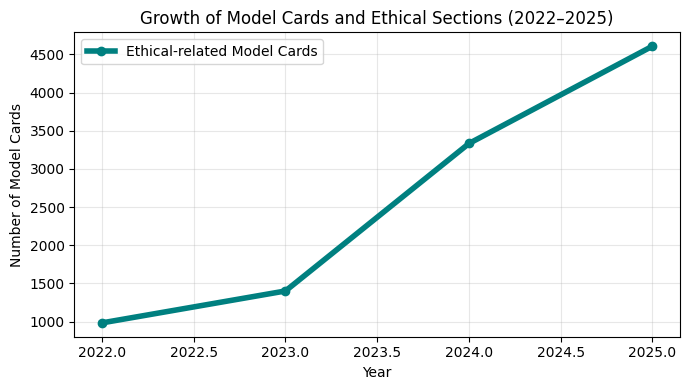

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(bias_cards_per_year.index, bias_cards_per_year.values, label="Ethical-related Model Cards", marker="o", color="teal", linewidth=4)
plt.title("Growth of Model Cards and Ethical Sections (2022–2025)")
plt.xlabel("Year")
plt.ylabel("Number of Model Cards")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

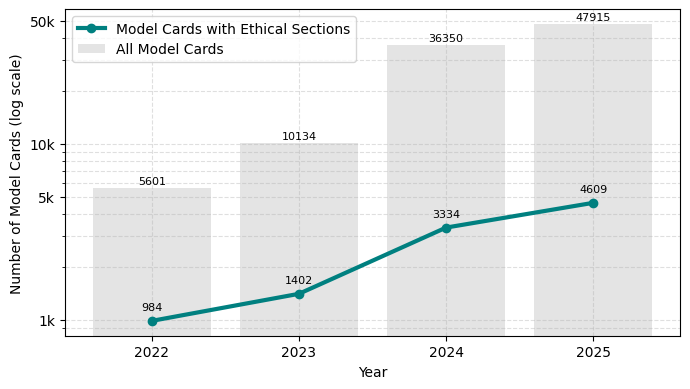

In [ ]:
plt.figure(figsize=(7,4))

# All Model Cards
plt.bar(all_cards_per_year.index, all_cards_per_year.values, 
        color="lightgray", alpha=0.6, label="All Model Cards")

# Model Cards with Ethical Sections
plt.plot(bias_cards_per_year.index, bias_cards_per_year.values, 
         color="teal", linewidth=3, marker="o", label="Model Cards with Ethical Sections")

plt.yscale("log")  # log scale

plt.yticks([1e3, 5e3, 1e4, 5e4], ["1k", "5k", "10k", "50k"])

plt.xticks(all_cards_per_year.index, labels=[str(year) for year in all_cards_per_year.index])
for x, y in zip(bias_cards_per_year.index, bias_cards_per_year.values):
    plt.text(x, y*1.15, f"{y}", ha="center", fontsize=8)

for x, y in zip(all_cards_per_year.index, all_cards_per_year.values):
    plt.text(x, y*1.05, f"{y}", ha="center", fontsize=8)


plt.xlabel("Year")
plt.ylabel("Number of Model Cards (log scale)")
plt.legend()
plt.grid(alpha=0.4, which="both", linestyle="--")
plt.tight_layout()
plt.savefig("growth_mcs_ethics.pdf", format="pdf")
plt.show()

###  **Metadata Analysis:**

**Pipeline tag or Task**

In [ ]:
data_bias_final["pipeline_tag"].value_counts(normalize=True) * 100

pipeline_tag
text-generation                   54.073449
image-text-to-text                 8.062474
text-classification                7.112706
text-to-image                      5.223723
automatic-speech-recognition       4.041790
image-classification               2.849304
fill-mask                          2.184466
sentence-similarity                2.015618
image-to-text                      1.720135
token-classification               1.688476
feature-extraction                 1.424652
translation                        1.002533
image-segmentation                 0.949768
object-detection                   0.612073
audio-classification               0.601520
image-to-image                     0.569861
video-classification               0.559308
image-feature-extraction           0.527649
zero-shot-image-classification     0.485437
text-to-speech                     0.453778
question-answering                 0.432672
text-to-audio                      0.390460
summarization      

**Library**

In [63]:
data_bias_final["library_name"].value_counts(normalize=True) * 100

library_name
transformers                74.466519
peft                        12.233260
diffusers                    5.463576
sentence-transformers        2.078734
cosmos                       0.993377
                              ...    
Electricity-Meter-OCR-7B     0.009198
wham                         0.009198
fairseq                      0.009198
DiffusionRenderer            0.009198
sklearn                      0.009198
Name: proportion, Length: 62, dtype: float64

**Author**

In [64]:
data_bias_final["author"].value_counts().head(20)

author
RichardErkhov        857
google               565
unsloth              442
nvidia               377
TheBloke             255
EleutherAI           239
allenai              228
facebook             213
QuantFactory         204
CodeAtCMU            165
giovannidemuri       152
Mungert              152
microsoft            145
stabilityai          144
meta-llama           134
Salesforce           116
GaetanMichelet        92
clembench-playpen     88
mav23                 84
mini1013              78
Name: count, dtype: int64

**Word count**

In [65]:
data_bias_final.groupby("model_id")["word_count"].sum().describe()

count    10329.000000
mean        82.509343
std        159.503901
min          0.000000
25%         14.000000
50%         24.000000
75%         80.000000
max       6033.000000
Name: word_count, dtype: float64

In [66]:
unique_models = data_bias_final.drop_duplicates(subset="model_id")
unique_models["card_length"].describe()

count     10329.000000
mean      10031.687675
std       18788.187836
min         475.000000
25%        3806.000000
50%        5178.000000
75%       10331.000000
max      651816.000000
Name: card_length, dtype: float64

**Correlations**

In [67]:
corr = data_bias_final.groupby("model_id")[["word_count", "card_length"]].sum().corr()
corr

,word_count,card_length
word_count,1.000000,0.623233
card_length,0.623233,1.000000


### **Content Analysis of Ethical Sections:**

1. Preprocessing and normalization of text within sections.
2. Computation of basic metrics.
3. Thematic analysis (Topic Modeling) applying Latent Dirichlet Allocation (LDA).

In [69]:
data_bias_final.dtypes

model_id         object
header           object
section_text     object
word_count        int64
author           object
created_at       object
last_modified    object
downloads         int64
likes             int64
has_card           bool
card_length       int64
library_name     object
tags             object
pipeline_tag     object
year              int32
category         object
dtype: object

**1. Preprocessing and normalization of text within sections**


In [70]:
data_bias_final.head()

,model_id,header,section_text,word_count,author,created_at,last_modified,downloads,likes,has_card,card_length,library_name,tags,pipeline_tag,year,category
0,Falconsai/nsfw_image_detection,intended uses and limitations,,0,Falconsai,2023-10-13T23:50:01+00:00,2025-04-06T13:42:07+00:00,98988953,824,True,9142,transformers,"transformers, pytorch, safetensors, vit, image...",image-classification,2023,limitation
1,Falconsai/nsfw_image_detection,limitations,- **Specialized Task Fine-Tuning**: While the ...,44,Falconsai,2023-10-13T23:50:01+00:00,2025-04-06T13:42:07+00:00,98988953,824,True,9142,transformers,"transformers, pytorch, safetensors, vit, image...",image-classification,2023,limitation
2,google-bert/bert-base-uncased,intended uses and limitations,\nYou can use the raw model for either masked ...,95,google-bert,2022-03-02T23:29:04+00:00,2024-02-19T11:06:12+00:00,55171860,2417,True,10516,transformers,"transformers, pytorch, tf, jax, rust, coreml, ...",fill-mask,2022,limitation
3,google-bert/bert-base-uncased,limitations and bias,\nEven if the training data used for this mode...,220,google-bert,2022-03-02T23:29:04+00:00,2024-02-19T11:06:12+00:00,55171860,2417,True,10516,transformers,"transformers, pytorch, tf, jax, rust, coreml, ...",fill-mask,2022,bias
4,FacebookAI/roberta-large,intended uses and limitations,\n\n\nYou can use the raw model for masked lan...,90,FacebookAI,2022-03-02T23:29:04+00:00,2024-02-19T12:47:04+00:00,13086830,247,True,9278,transformers,"transformers, pytorch, tf, jax, onnx, safetens...",fill-mask,2022,limitation


In [ ]:
# Main text cleaning
def clean_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""
    
    # HTML comments / tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    
    # Lowercase
    text = text.lower()
    
    # URLs / emails
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # Markdown code / inline code
    text = re.sub(r'`{1,3}.*?`{1,3}', ' ', text)
    # Markdown links [text](url) -> keep text
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)
    # Images
    text = re.sub(r'!\[.*?\]\(.*?\)', ' ', text)
    # Headers
    text = re.sub(r'#+', ' ', text)
    
    # Remove emojis
    text = emoji.replace_emoji(text, replace=' ')
   
    # Only letters/numbers/spaces
    text = re.sub(r'[^a-záéíóúüñ0-9\s]', ' ', text)
    
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Filter placeholders
    placeholders = ["todo", "tbd", "more information needed", "n/a", "none"]
    if any(p in text for p in placeholders):
        return ""
    
    return text

In [72]:
data_bias_final["cleaned_text"] = data_bias_final["section_text"].apply(clean_text)

In [ ]:
texts = data_bias_final['preprocessed_text'].tolist()

custom_stopwords = {
    "datum", "llama", "s"}

In [ ]:
# Text preprocessing using spaCy: tokenization, lemmatization, and custom stopword removal

nlp = spacy.load("en_core_web_sm") 

def preprocess_spacy(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop
        and token.is_alpha
        and token.lemma_.lower() not in custom_stopwords
    ]
    return " ".join(tokens)

# data_bias_final["preprocessed_text"] = data_bias_final["cleaned_text"].apply(preprocess_spacy)

In [ ]:
from tqdm import tqdm

texts = data_bias_final["cleaned_text"].tolist()
preprocessed_texts = []

for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts)):
    preprocessed_texts.append(preprocess_spacy(doc.text))

data_bias_final["preprocessed_text"] = preprocessed_texts

100%|██████████| 13071/13071 [03:28<00:00, 62.61it/s] 


In [ ]:
# Remove rows where section_text is empty or contains only whitespace
data_bias_final = data_bias_final[data_bias_final['preprocessed_text'].str.strip() != ""].copy()

In [77]:
data_bias_final[["cleaned_text", "preprocessed_text"]].head(10)

,cleaned_text,preprocessed_text
1,specialized task fine tuning while the model i...,specialized task fine tuning model adept nsfw ...
2,you can use the raw model for either masked la...,use raw model mask language modeling sentence ...
3,even if the training data used for this model ...,training datum model characterize fairly neutr...
4,you can use the raw model for masked language ...,use raw model masked language modeling s inten...
5,the training data used for this model contains...,training datum model contain lot unfiltered co...
7,clip and our analysis of it have a number of l...,clip analysis number limitation clip currently...
8,we find that the performance of clip and the s...,find performance clip specific bias exhibit de...
9,you can use the raw model for either masked la...,use raw model mask language modeling sentence ...
10,even if the training data used for this model ...,training datum model characterize fairly neutr...
11,you can use the raw model for text generation ...,use raw model text generation fine tune downst...


In [78]:
data_bias_final[["section_text"]].tail(10)

,section_text
13017,\nWhile the model is designed to improve inter...
13019,- **Limited Scope**: The model has been specif...
13023,The model was trained on a dataset that includ...
13024,- The model may produce biased or offensive ou...
13039,"\nLike any base or fine-tuned language model, ..."
13046,\nThese models are intended to be used for res...
13047,\nLarge Language Models may generate text that...
13048,\nYou can use the raw model for object detecti...
13053,NVIDIA believes Trustworthy AI is a shared res...
13054,\nNVIDIA believes Trustworthy AI is a shared r...


**2. Computation of basic metrics**

In [ ]:
# Unique words
unique_words = data_bias_final['preprocessed_text'].apply(
    lambda x: len(set(re.findall(r'\b\w+\b', x))) if isinstance(x, str) else 0
)

unique_words.mean()

np.float64(40.49136836760599)

In [ ]:
# Relative lexical variety (Type-Token Ratio, TTR)
type_token_ratio = data_bias_final['preprocessed_text'].apply(
    lambda x: (len(set(re.findall(r'\b\w+\b', x))) / len(re.findall(r'\b\w+\b', x)))
    if isinstance(x, str) and len(re.findall(r'\b\w+\b', x)) > 0 else 0
)

type_token_ratio.mean()

np.float64(0.8515027983080293)

In [ ]:
# Lexical complexity (average word length)
avg_word_length = data_bias_final['preprocessed_text'].apply(
    lambda x: np.mean([len(w) for w in re.findall(r'\b\w+\b', x)]) if isinstance(x, str) and len(re.findall(r'\b\w+\b', x)) > 0 else 0
)

avg_word_length.mean()

np.float64(6.578409351868531)

**3. Thematic analysis (Topic Modeling): LDA**

In [ ]:
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel


# Tokenize preprocessed text into lists of words for LDA
tokenized_texts = [t.split() for t in data_bias_final["preprocessed_text"] if t.strip()]

# Create a dictionary
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=3, no_above=0.6)

# Convert each document to bag-of-words format
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [ ]:
# Flatten all tokenized texts into a single list of words
all_words = [token for doc in tokenized_texts for token in doc]

freq = Counter(all_words)
freq.most_common(50)

[('model', 22405),
 ('use', 6969),
 ('language', 4745),
 ('safety', 4177),
 ('bias', 3915),
 ('content', 3814),
 ('training', 3719),
 ('generate', 3636),
 ('user', 3525),
 ('developer', 3164),
 ('case', 3159),
 ('application', 2997),
 ('risk', 2992),
 ('text', 2903),
 ('output', 2809),
 ('ai', 2331),
 ('train', 2305),
 ('limitation', 2275),
 ('llm', 2223),
 ('prompt', 2214),
 ('information', 2166),
 ('task', 2101),
 ('dataset', 2034),
 ('response', 2010),
 ('responsible', 1997),
 ('produce', 1989),
 ('misuse', 1966),
 ('fine', 1942),
 ('base', 1921),
 ('specific', 1878),
 ('performance', 1728),
 ('provide', 1726),
 ('include', 1626),
 ('context', 1586),
 ('work', 1579),
 ('english', 1559),
 ('image', 1521),
 ('harmful', 1436),
 ('perform', 1408),
 ('technology', 1403),
 ('deploy', 1390),
 ('evaluation', 1385),
 ('testing', 1371),
 ('capability', 1364),
 ('generation', 1282),
 ('tuning', 1268),
 ('code', 1221),
 ('like', 1204),
 ('development', 1197),
 ('potential', 1188)]

In [ ]:
# LDA Model training
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    random_state=42,
    passes=30,
    alpha='auto',
    eta='auto'
)

# Coherence
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=tokenized_texts, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherencia:', coherence_lda)


Coherencia: 0.45296126256487507


In [ ]:
for idx, topic in lda_model.show_topics(num_words=6, formatted=False):
    print(f"Topic {idx}: {[word for word, _ in topic]}")

Topic 0: ['use', 'developer', 'misuse', 'ai', 'safety', 'bias']
Topic 1: ['language', 'generate', 'bias', 'content', 'text', 'output']
Topic 2: ['safety', 'use', 'user', 'risk', 'llm', 'testing']


**Topic Visualization**

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)

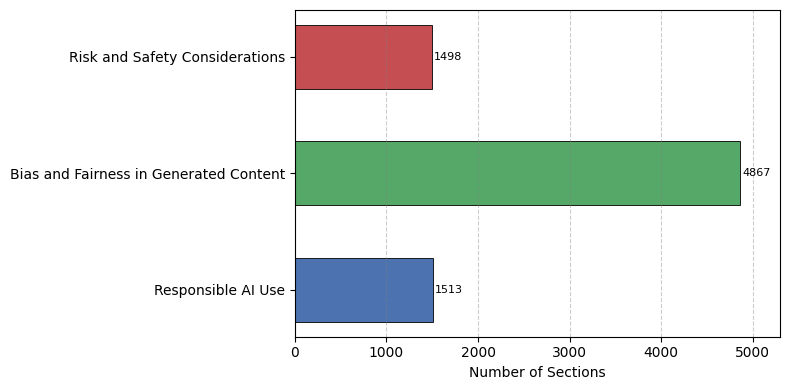

In [ ]:
data_bias_final["dominant_topic"] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]
topic_counts = data_bias_final["dominant_topic"].value_counts().sort_index()

topic_labels = ["Responsible AI Use", "Bias and Fairness in Generated Content", "Risk and Safety Considerations"]

colors = ["#4c72b0", "#55a868", "#c44e52"]

plt.figure(figsize=(8,4))
bars = plt.barh(topic_labels, topic_counts, color=colors, edgecolor="black", height=0.55, linewidth=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 20, bar.get_y() + bar.get_height()/2, int(width), va='center', fontsize=8)

plt.xlabel("Number of Sections", fontsize=10)
plt.yticks(fontsize=10) 
plt.xlim(0, 5300) 

plt.grid(axis='x', linestyle='--', color='gray', alpha=0.4)

plt.tight_layout()
plt.savefig("lda_topics.pdf", format="pdf")
plt.show()


In [91]:
topic_counts

dominant_topic
0    1512
1    4868
2    1498
Name: count, dtype: int64